In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.regression.linear_model import OLS
from itertools import product as iterproduct


In [167]:
# Scan data folder for all CSVs
folder_path = r'data'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create dictionary to store returns & names of stocks
comm_name = {}
price_df = {}
# Calculate returns for each stock
for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    file = file.replace('.csv','')
    price_df[file] = df[file]
    comm_name[file] = file
    dates = df["observation_date"]

price_df = pd.DataFrame(price_df)
price_df.index = pd.to_datetime(dates)

display(price_df)

,DCOILBRENTEU,DCOILWTICO,DDFUELLA,DDFUELNYH,DDFUELUSGULF,DGASNYH,DGASUSGULF,DJFUELUSGULF,DPROPANEMBTX
observation_date,,,,,,,,,
2020-01-02,67.05,61.17,2.097,2.019,1.947,1.744,1.679,1.934,0.441
2020-01-03,69.08,63.00,2.114,2.054,1.974,1.792,1.729,1.972,0.465
2020-01-06,70.25,63.27,2.089,2.019,1.944,1.783,1.716,1.941,0.470
2020-01-07,68.74,62.70,2.094,2.024,1.947,1.758,1.698,1.949,0.466
2020-01-08,67.31,59.65,1.997,1.967,1.887,1.698,1.628,1.892,0.453
...,...,...,...,...,...,...,...,...,...
2024-12-26,NaN,70.38,2.224,2.184,2.127,2.016,1.988,2.089,0.763
2024-12-27,73.77,71.28,2.257,2.217,2.158,2.020,1.980,2.122,0.771
2024-12-30,74.24,71.73,2.324,2.284,2.225,2.048,2.008,2.189,0.780


Column 'DCOILBRENTEU' has 40 NaN values
Column 'DCOILWTICO' has 53 NaN values
Column 'DDFUELLA' has 59 NaN values
Column 'DDFUELNYH' has 54 NaN values
Column 'DDFUELUSGULF' has 54 NaN values
Column 'DGASNYH' has 54 NaN values
Column 'DGASUSGULF' has 54 NaN values
Column 'DJFUELUSGULF' has 54 NaN values
Column 'DPROPANEMBTX' has 54 NaN values


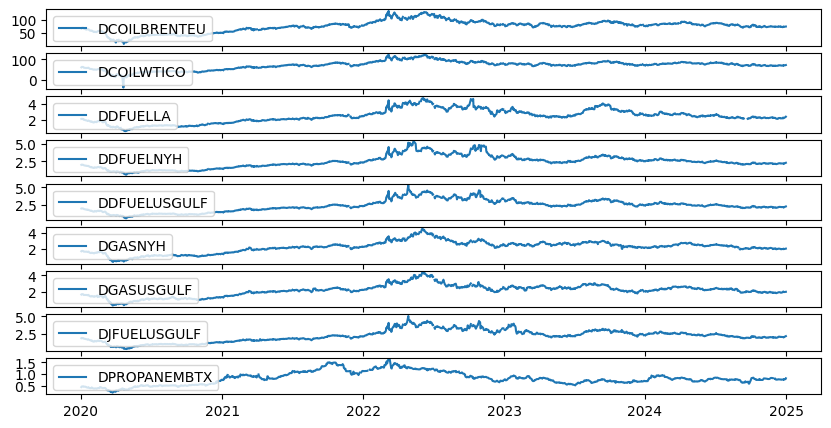

In [168]:
# Plot each time Series
fig,ax  = plt.subplots(len(price_df.columns),1,figsize=(10,5))
ax = ax.flatten()
for i,col in enumerate(price_df.columns):
    na_count = price_df[col].isna().sum()
    print(f"Column '{col}' has {na_count} NaN values")    
    ax[i].plot(price_df[col],label=col)
    ax[i].legend(loc="upper left")

In [169]:
na_counts = pd.DataFrame({
    'Column': price_df.columns,
    'NaN Count': price_df.isna().sum(),
    '% Missing': (price_df.isna().mean() * 100).round(1)
})

# Print formatted table
print("\nMissing Value Report:")
print(na_counts.to_string(index=False))

# Optional: Display as markdown table for better readability
from IPython.display import Markdown
display(Markdown(na_counts.to_markdown(index=False)))


Missing Value Report:
      Column  NaN Count  % Missing
DCOILBRENTEU         40        3.1
  DCOILWTICO         53        4.1
    DDFUELLA         59        4.5
   DDFUELNYH         54        4.1
DDFUELUSGULF         54        4.1
     DGASNYH         54        4.1
  DGASUSGULF         54        4.1
DJFUELUSGULF         54        4.1
DPROPANEMBTX         54        4.1


| Column       |   NaN Count |   % Missing |
|:-------------|------------:|------------:|
| DCOILBRENTEU |          40 |         3.1 |
| DCOILWTICO   |          53 |         4.1 |
| DDFUELLA     |          59 |         4.5 |
| DDFUELNYH    |          54 |         4.1 |
| DDFUELUSGULF |          54 |         4.1 |
| DGASNYH      |          54 |         4.1 |
| DGASUSGULF   |          54 |         4.1 |
| DJFUELUSGULF |          54 |         4.1 |
| DPROPANEMBTX |          54 |         4.1 |

C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\320752860.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x800 with 0 Axes>

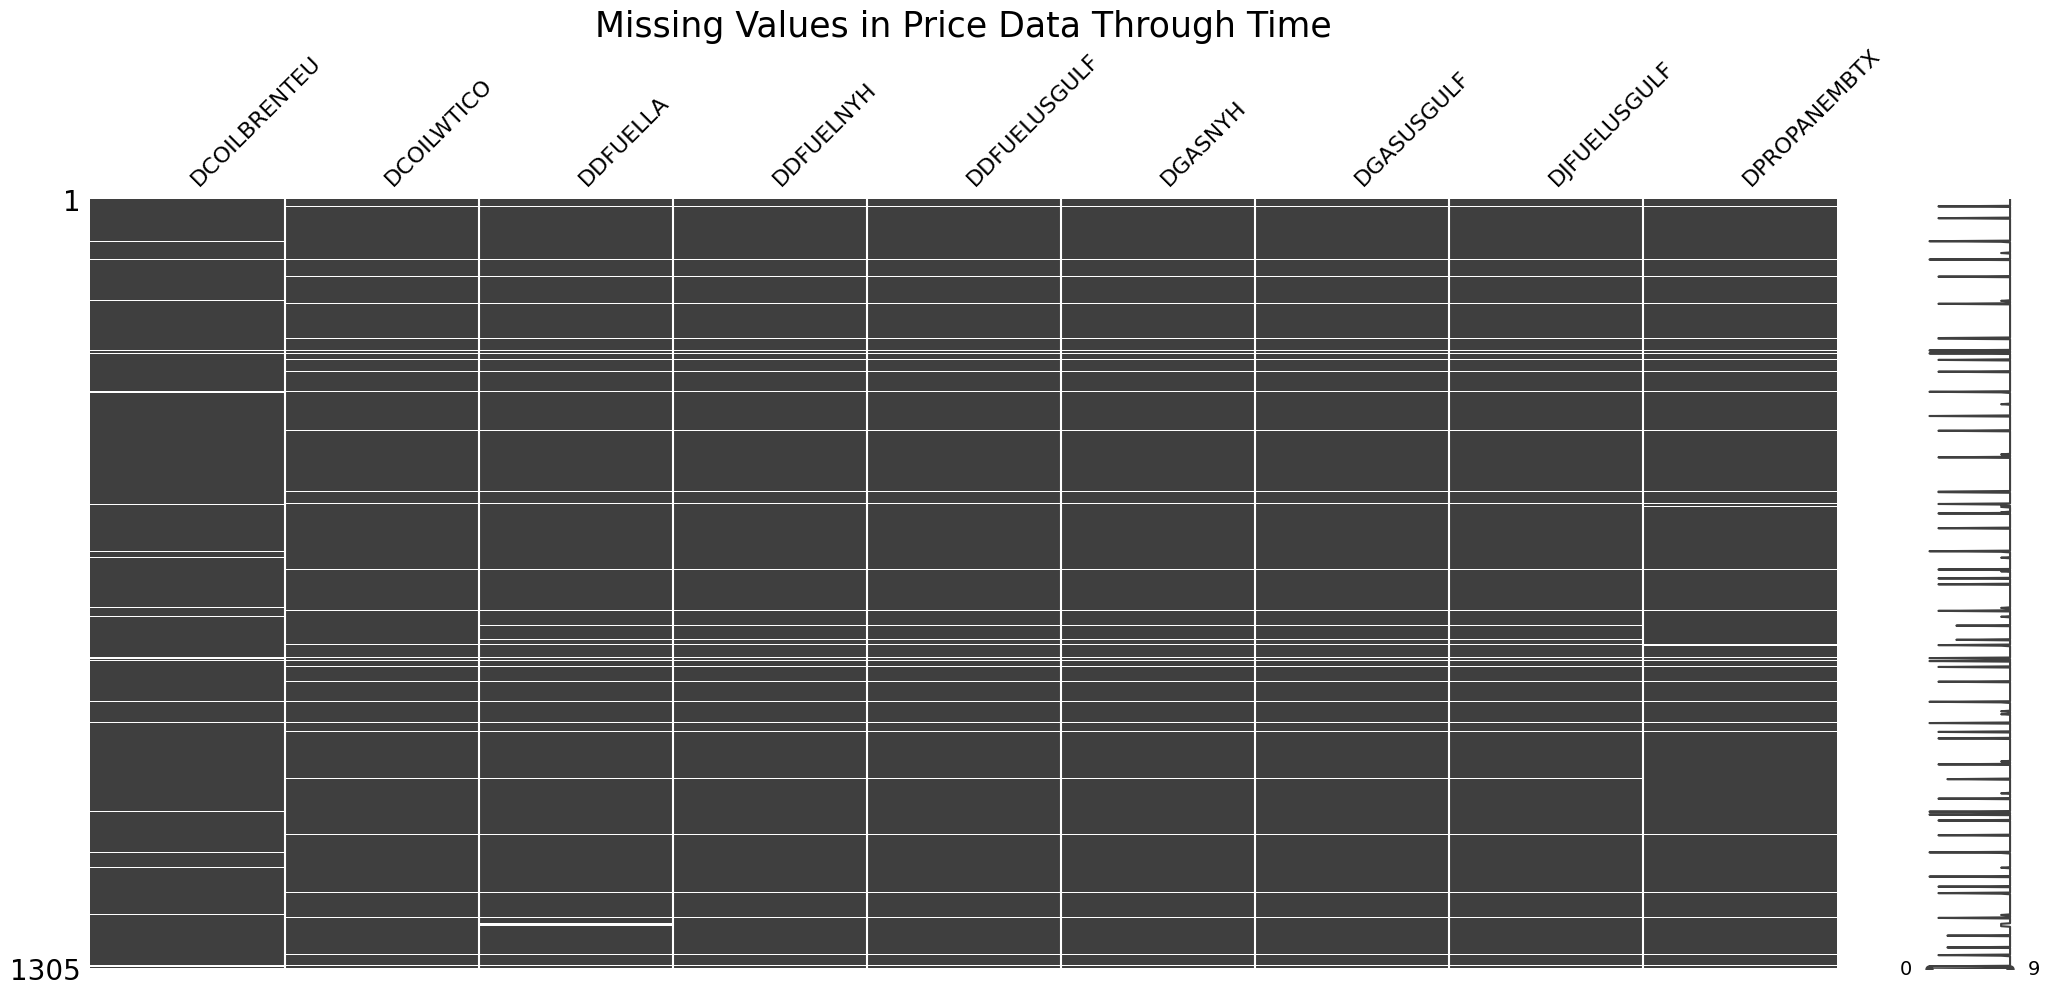

In [170]:
import missingno as msno
plt.figure(figsize=(8, 8))  # Width, Height in inches
msno.matrix(price_df)
plt.tight_layout()
plt.title("Missing Values in Price Data Through Time",fontsize=25)
plt.show()

In [171]:

def get_longest_non_na_streak(series):
    
    # Convert to numpy array for faster processing
    non_na = series.notna().to_numpy()
    n = len(non_na)
    
    if not non_na.any():
        return {'length': 0, 'start': None, 'end': None, 'start_pos': -1, 'end_pos': -1}
    
    # Find all transition points between NA/non-NA
    transitions = np.where(non_na[:-1] != non_na[1:])[0] + 1
    transitions = np.concatenate(([0], transitions, [n]))
    
    # Calculate streak lengths (only for non-NA periods)
    streak_lengths = np.diff(transitions)[::2] if non_na[0] else np.diff(transitions)[1::2]
    
    if len(streak_lengths) == 0:
        return {'length': 0, 'start': None, 'end': None, 'start_pos': -1, 'end_pos': -1}
    
    # Find position of longest streak
    longest_idx = np.argmax(streak_lengths)
    longest_len = streak_lengths[longest_idx]
    
    # Calculate start and end positions
    if non_na[0]:
        start_pos = transitions[2*longest_idx]
    else:
        start_pos = transitions[2*longest_idx + 1]
    end_pos = start_pos + longest_len - 1
    
    return {
        'length': int(longest_len),
        'start': series.index[start_pos],
        'end': series.index[end_pos],
        'start_pos': start_pos,
        'end_pos': end_pos
    }

# Apply to each column and convert to DataFrame
streak_results = price_df.apply(get_longest_non_na_streak).apply(pd.Series)
print(streak_results)

              length      start        end  start_pos  end_pos
DCOILBRENTEU      86 2024-08-27 2024-12-24       1213     1298
DCOILWTICO        57 2020-09-08 2020-11-25        178      234
DDFUELLA          57 2020-09-08 2020-11-25        178      234
DDFUELNYH         57 2020-09-08 2020-11-25        178      234
DDFUELUSGULF      57 2020-09-08 2020-11-25        178      234
DGASNYH           57 2020-09-08 2020-11-25        178      234
DGASUSGULF        57 2020-09-08 2020-11-25        178      234
DJFUELUSGULF      57 2020-09-08 2020-11-25        178      234
DPROPANEMBTX      62 2024-09-03 2024-11-27       1218     1279


Text(0.5, 1.0, 'Longest period of consistent data for method testing')

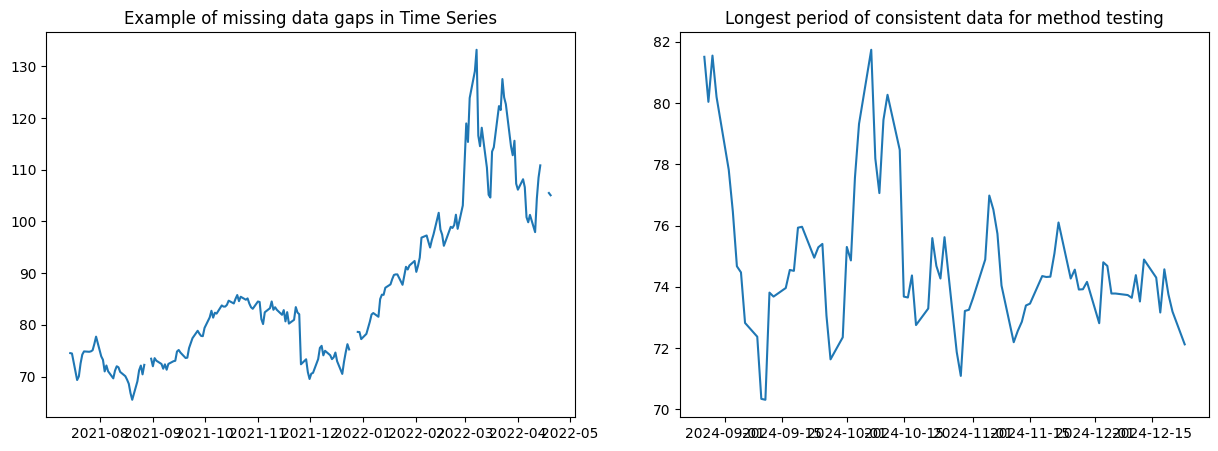

In [172]:
# Evaluate a method for filling NAs
fig , ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(price_df["DCOILBRENTEU"][400:600])
ax[0].set_title("Example of missing data gaps in Time Series")
ax[1].plot(price_df["DCOILBRENTEU"].iloc[1213:1298])
ax[1].set_title("Longest period of consistent data for method testing")

In [173]:
# MA Fill
def moving_average_fill(series, window=5):
    """
    Fill missing values using moving average
    window: Number of periods to include in MA calculation
    """
    ma = series.rolling(window=window, min_periods=1, center=True).mean()
    return series.fillna(ma)



In [174]:
# Forward backward hyrbid Fill
def locf_nocb_fill(series):
    """Fill gaps using forward fill, then backward fill"""
    return series.ffill().bfill()



In [175]:
# Create artificially Gappes brent series
og_brent = price_df["DCOILBRENTEU"].iloc[1213:1298]
artf_brent = og_brent.copy()
length_artf = len(artf_brent)
num_gaps = int(np.ceil(length_artf * 0.01))  # Adjust for average gap length

indices_to_nan = np.random.choice(length_artf, size=num_gaps, replace=False)
indices_to_nan.sort()

nan_indices_set = set(indices_to_nan)
final_nan_indices = []

i = 0
while i < len(indices_to_nan):
    start_index = indices_to_nan[i]
    gap_length = 1  # Generate gap length of 1 or 2
    for j in range(gap_length):
        index_to_nan = start_index + j
        if 0 <= index_to_nan < length_artf:
            final_nan_indices.append(index_to_nan)
    i += gap_length

# Apply NaN values
artf_brent[final_nan_indices] = np.nan


C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\4111601289.py:24: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  artf_brent[final_nan_indices] = np.nan


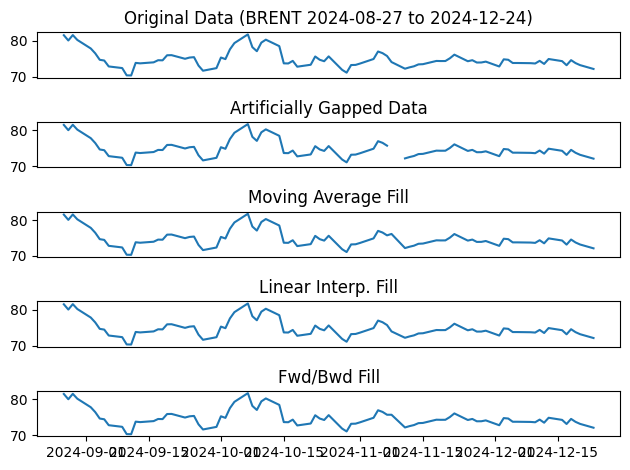

In [176]:

filled_brent_MA = artf_brent.fillna(artf_brent.rolling(3, min_periods=1).mean())
filled_brent_linear = artf_brent.interpolate(method='linear')
filled_brent_hybrid = locf_nocb_fill(artf_brent)
fig,ax = plt.subplots(5,1)
ax[0].plot(og_brent)
ax[0].set_title("Original Data (BRENT 2024-08-27 to 2024-12-24)")
ax[0].set_xticks([])
ax[1].plot(artf_brent)
ax[1].set_title("Artificially Gapped Data")
ax[1].set_xticks([])
ax[2].plot(filled_brent_MA)
ax[2].set_title("Moving Average Fill")
ax[2].set_xticks([])
ax[3].plot(filled_brent_linear)
ax[3].set_title("Linear Interp. Fill")
ax[3].set_xticks([])
ax[4].plot(filled_brent_hybrid)
ax[4].set_title("Fwd/Bwd Fill")
plt.tight_layout()


In [177]:

def calculate_gap_metrics(original, predicted):
   
    # Align the series and remove non-gap positions
    aligned = pd.DataFrame({'original': original, 'predicted': predicted})
    gap_points = aligned[aligned['predicted'].notna() & aligned['original'].notna()]
    
    true = gap_points['original']
    pred = gap_points['predicted']
    
    # Calculate errors
    errors = pred - true
    abs_errors = np.abs(errors)
    abs_pct_errors = abs_errors / true
    
    # Compute metrics
    metrics = {
        'MSE': np.mean(errors**2),
        'RMSE': np.sqrt(np.mean(errors**2)),
        'MAE': np.mean(abs_errors),
        'MAPE': np.mean(abs_pct_errors) * 100  # as percentage
    }
    
    return metrics



In [178]:
# Calculate metrics for all methods
metrics_MA = calculate_gap_metrics(og_brent, filled_brent_MA)
metrics_Linear = calculate_gap_metrics(og_brent, filled_brent_linear)
metrics_Hybrid = calculate_gap_metrics(og_brent, filled_brent_hybrid)

# Create a comparison table
results = pd.DataFrame({
    'Moving Average': metrics_MA,
    'Linear Interpolation': metrics_Linear,
    'Forwards/Backwards Fill': metrics_Hybrid
}).T

# Format the output nicely
formatted_results = results.style.format({
    'MSE': '{:.4f}',
    'RMSE': '{:.4f}',
    'MAE': '{:.4f}',
    'MAPE': '{:.2f}%'
})

print("Gap-Filling Method Comparison:")
display(formatted_results)

Gap-Filling Method Comparison:


,MSE,RMSE,MAE,MAPE
Moving Average,0.0511,0.2262,0.0245,0.03%
Linear Interpolation,0.0001,0.0087,0.0009,0.00%
Forwards/Backwards Fill,0.0336,0.1833,0.0199,0.03%


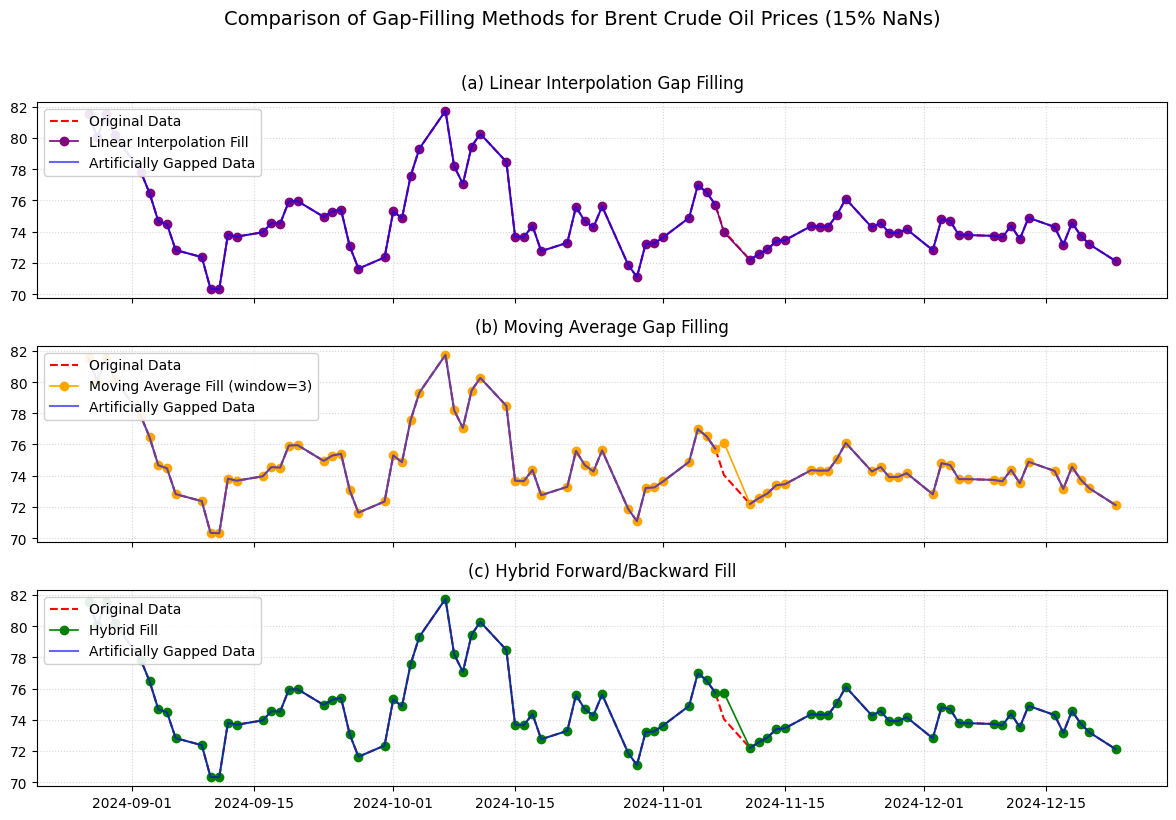

In [179]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Plot 1: Linear Interpolation
ax[0].plot(og_brent, color="red",linestyle="--", linewidth=1.5, label="Original Data")
ax[0].plot(filled_brent_linear, color="purple", marker="o", linestyle="-", linewidth=1.2, label="Linear Interpolation Fill")
ax[0].plot(artf_brent, color="blue", markersize=3, label="Artificially Gapped Data", alpha=0.6)
ax[0].set_title("(a) Linear Interpolation Gap Filling", fontsize=12, pad=10)
ax[0].legend(loc="upper left", framealpha=0.9)
ax[0].grid(True, linestyle=':', alpha=0.5)

# Plot 2: Moving Average
ax[1].plot(og_brent, color="red",linestyle="--", linewidth=1.5, label="Original Data")
ax[1].plot(filled_brent_MA, color="orange", marker="o", linestyle="-", linewidth=1.2, label="Moving Average Fill (window=3)")
ax[1].plot(artf_brent, color="blue", markersize=3, label="Artificially Gapped Data", alpha=0.6)
ax[1].set_title("(b) Moving Average Gap Filling", fontsize=12, pad=10)
ax[1].legend(loc="upper left", framealpha=0.9)
ax[1].grid(True, linestyle=':', alpha=0.5)

# Plot 3: Hybrid Method
ax[2].plot(og_brent, color="red",linestyle="--", linewidth=1.5, label="Original Data")
ax[2].plot(filled_brent_hybrid, color="green", marker="o", linestyle="-", linewidth=1.2, label="Hybrid Fill")
ax[2].plot(artf_brent,color="blue", markersize=3, label="Artificially Gapped Data", alpha=0.6)
ax[2].set_title("(c) Hybrid Forward/Backward Fill", fontsize=12, pad=10)
ax[2].legend(loc="upper left", framealpha=0.9)
ax[2].grid(True, linestyle=':', alpha=0.5)

plt.suptitle("Comparison of Gap-Filling Methods for Brent Crude Oil Prices (15% NaNs)", 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\1742200254.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x800 with 0 Axes>

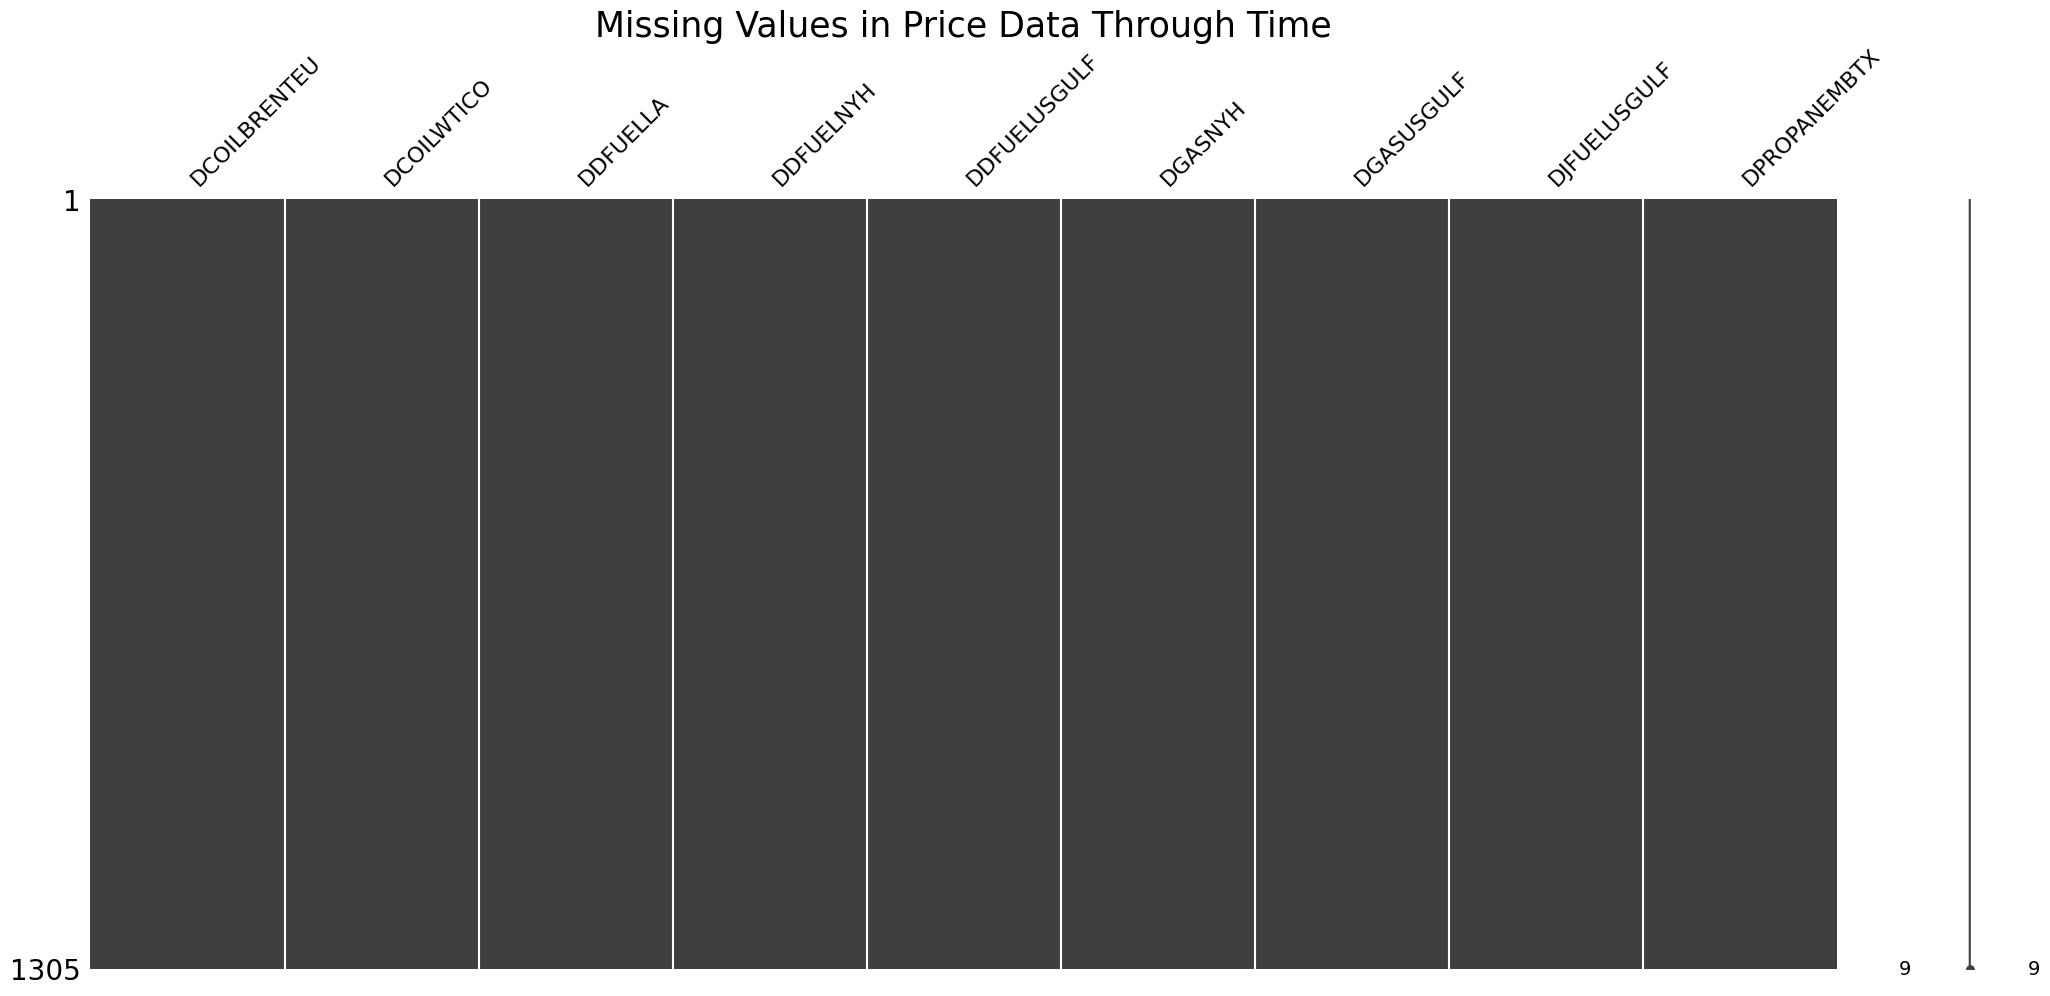

In [180]:
# Fill in all data using linear Interp
for product in price_df.columns:
    price_df[product] = price_df[product].interpolate(method='linear')

#check
plt.figure(figsize=(8, 8))  # Width, Height in inches
msno.matrix(price_df)
plt.tight_layout()
plt.title("Missing Values in Price Data Through Time",fontsize=25)
plt.show()

In [181]:
# Differnce the data to get returns
returns_df = price_df.copy()
for product in returns_df.columns:
    returns_df[product] = np.log(price_df[product]/price_df[product].shift(1))

returns_df = returns_df.dropna()
returns_df

C:\Users\dbjac\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,DCOILBRENTEU,DCOILWTICO,DDFUELLA,DDFUELNYH,DDFUELUSGULF,DGASNYH,DGASUSGULF,DJFUELUSGULF,DPROPANEMBTX
observation_date,,,,,,,,,
2020-01-03,0.029827,0.029478,0.008074,0.017187,0.013772,0.027151,0.029345,0.019458,0.052993
2020-01-06,0.016795,0.004277,-0.011896,-0.017187,-0.015314,-0.005035,-0.007547,-0.015845,0.010695
2020-01-07,-0.021729,-0.009050,0.002391,0.002473,0.001542,-0.014121,-0.010545,0.004113,-0.008547
2020-01-08,-0.021022,-0.049867,-0.047430,-0.028566,-0.031301,-0.034726,-0.042099,-0.029682,-0.028294
2020-01-09,-0.010905,-0.001510,0.001001,-0.010734,-0.011191,-0.001179,0.000000,-0.009559,0.015334
...,...,...,...,...,...,...,...,...,...
2024-12-26,0.001222,-0.003475,-0.004486,-0.004568,-0.004690,-0.005442,-0.006268,-0.001435,0.000000
2024-12-27,0.001221,0.012707,0.014729,0.014997,0.014469,0.001982,-0.004032,0.015674,0.010430
2024-12-30,0.006351,0.006293,0.029253,0.029773,0.030575,0.013766,0.014042,0.031086,0.011606


Column 'DCOILBRENTEU' has 0 NaN values
Column 'DCOILWTICO' has 0 NaN values
Column 'DDFUELLA' has 0 NaN values
Column 'DDFUELNYH' has 0 NaN values
Column 'DDFUELUSGULF' has 0 NaN values
Column 'DGASNYH' has 0 NaN values
Column 'DGASUSGULF' has 0 NaN values
Column 'DJFUELUSGULF' has 0 NaN values
Column 'DPROPANEMBTX' has 0 NaN values


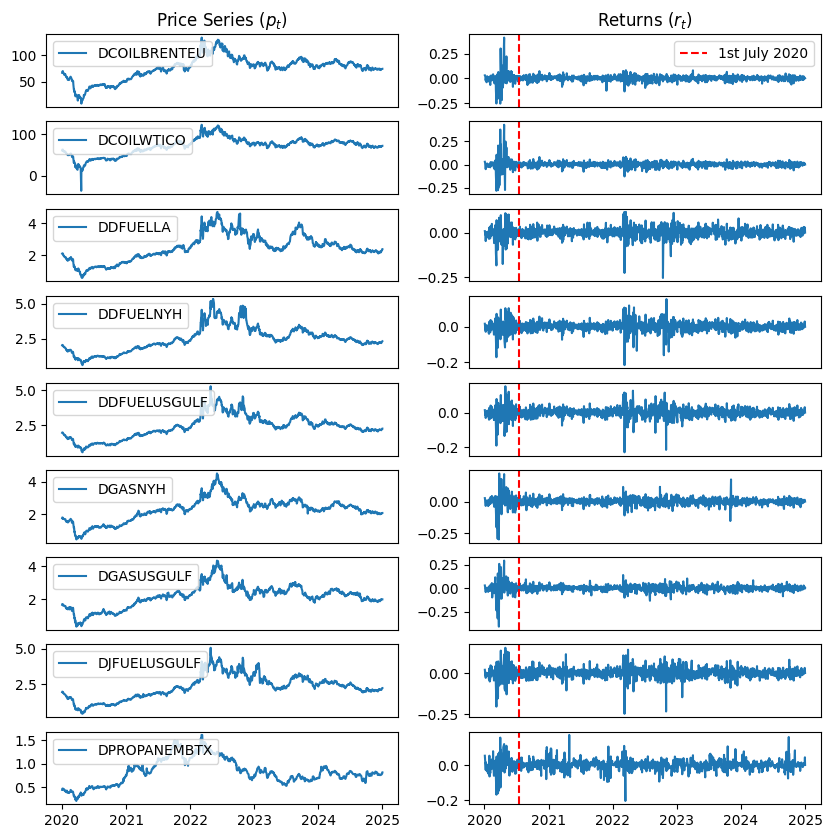

In [182]:
# Plot each time Series
fig,ax  = plt.subplots(len(price_df.columns),2,figsize=(10,10))
for i,col in enumerate(price_df.columns):
    na_count = price_df[col].isna().sum()
    print(f"Column '{col}' has {na_count} NaN values")    
    ax[i,0].plot(price_df[col],label=col)
    ax[i,0].legend(loc="upper left")
    ax[i,1].plot(returns_df[col])
    if i < (len(price_df.columns)-1):
        ax[i,0].set_xticks([])
        ax[i,1].set_xticks([])
    if i == 0:
        ax[i,0].set_title(f"Price Series ($p_t$)")
        ax[i,1].set_title(f"Returns ($r_t$)")
    ax[i,1].axvline(pd.to_datetime("2020-07-15"),color="red",linestyle="--",label="1st July 2020")

ax[0,1].legend()
plt.show()

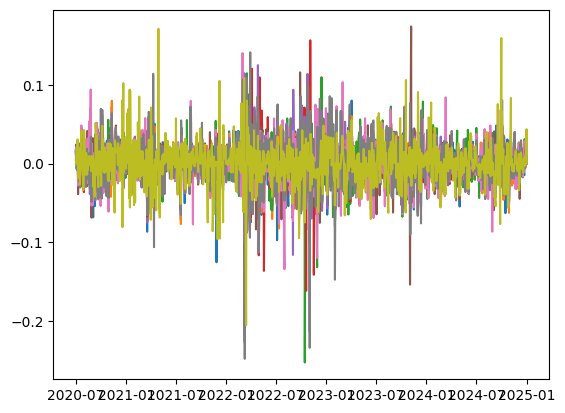

In [183]:
for product in returns_df.columns:
    returns_df[product] = returns_df[product].loc["2020-07-01":]

returns_df = returns_df.dropna()
plt.plot(returns_df)

In [184]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(returns_df):
    
    results = []
    
    for col in returns_df.columns:
        # Remove missing values for testing
        series = returns_df[col].dropna()
        
        # ADF Test
        adf_result = adfuller(series, autolag='AIC')
        adf_pvalue = adf_result[1]
        adf_h0_rejected = adf_pvalue < 0.05
        
        # KPSS Test
        try:
            kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
            kpss_pvalue = kpss_result[1]
            kpss_h0_rejected = kpss_pvalue < 0.05
        except:
            kpss_pvalue = None
            kpss_h0_rejected = None
        
        # Determine stationarity conclusion
        if adf_h0_rejected and not kpss_h0_rejected:
            conclusion = "Stationary"
        elif not adf_h0_rejected and kpss_h0_rejected:
            conclusion = "Non-Stationary"
        else:
            conclusion = "Inconclusive (may need differencing)"
        
        results.append({
            'Column': col,
            'ADF p-value':adf_pvalue,
            'ADF H0 Rejected (5%)': adf_h0_rejected,
            'KPSS p-value': round(kpss_pvalue, 4) if kpss_pvalue else None,
            'KPSS H0 Rejected (5%)': kpss_h0_rejected,
            'Conclusion': conclusion
        })
    
    return pd.DataFrame(results)

# Example usage:
stationarity_results = test_stationarity(returns_df)
print(stationarity_results.to_markdown(index=False))

C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
C:\Users\dbja

| Column       |   ADF p-value | ADF H0 Rejected (5%)   |   KPSS p-value | KPSS H0 Rejected (5%)   | Conclusion   |
|:-------------|--------------:|:-----------------------|---------------:|:------------------------|:-------------|
| DCOILBRENTEU |   1.12507e-28 | True                   |         0.1    | False                   | Stationary   |
| DCOILWTICO   |   6.1397e-27  | True                   |         0.1    | False                   | Stationary   |
| DDFUELLA     |   3.23968e-27 | True                   |         0.1    | False                   | Stationary   |
| DDFUELNYH    |   7.38699e-27 | True                   |         0.1    | False                   | Stationary   |
| DDFUELUSGULF |   2.09361e-28 | True                   |         0.1    | False                   | Stationary   |
| DGASNYH      |   0           | True                   |         0.0856 | False                   | Stationary   |
| DGASUSGULF   |   7.36266e-30 | True                   |         0.1   

C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend
C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\201422591.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend


In [185]:

def find_optimal_lags(y, x, max_lags=12):
    """Grid search for optimal lags using AIC"""
    best_aic = np.inf
    best_lags = (1, 1)
    
    for y_lags, x_lags in iterproduct(range(1, max_lags+1), range(1, max_lags+1)):
        # Create fresh DataFrames for each iteration
        X = pd.DataFrame()
        for i in range(y_lags):
            X[f'y_lag_{i+1}'] = y.shift(i+1)
        for i in range(x_lags):
            X[f'x_lag_{i+1}'] = x.shift(i+1)
            
        # Drop NaN rows
        X = X.dropna()
        y_trim = y[X.index[0]:]
        
        if len(y_trim) < 30:  # Skip if not enough data
            continue
            
        # Fit model
        try:
            model = OLS(y_trim, sm.add_constant(X))
            results = model.fit()
            
            # Calculate AIC
            aic = len(y_trim) * np.log(np.var(results.resid)) + 2 * (y_lags + x_lags)
            
            if aic < best_aic:
                best_aic = aic
                best_lags = (y_lags, x_lags)
        except:
            continue
            
    return best_lags

def calculate_f_statistic(y, x, y_lags, x_lags):
    """Calculate F-statistic and various improvement metrics"""
    # Create fresh DataFrames
    X_restricted = pd.DataFrame(index=y.index)
    for i in range(y_lags):
        X_restricted[f'y_lag_{i+1}'] = y.shift(i+1)
    
    X_unrestricted = X_restricted.copy()
    for i in range(x_lags):
        X_unrestricted[f'x_lag_{i+1}'] = x.shift(i+1)
    
    # Drop NaN rows and align indices
    X_restricted = X_restricted.dropna()
    X_unrestricted = X_unrestricted.dropna()
    
    common_idx = X_unrestricted.index.intersection(X_restricted.index)
    common_idx = common_idx.intersection(y.index)
    
    X_restricted = X_restricted.loc[common_idx]
    X_unrestricted = X_unrestricted.loc[common_idx]
    y_trim = y.loc[common_idx]
    
    # Fit models
    model_restricted = OLS(y_trim, sm.add_constant(X_restricted))
    model_unrestricted = OLS(y_trim, sm.add_constant(X_unrestricted))
    
    results_restricted = model_restricted.fit()
    results_unrestricted = model_unrestricted.fit()
    
    # Calculate metrics
    var_restricted = np.var(results_restricted.resid)
    var_unrestricted = np.var(results_unrestricted.resid)
    
    var_improvement = ((var_restricted - var_unrestricted)/var_restricted) * 100
    r2_improvement = (results_unrestricted.rsquared - results_restricted.rsquared) * 100
    
    return {
        'var_improvement': var_improvement,
        'r2_restricted': results_restricted.rsquared,
        'r2_unrestricted': results_unrestricted.rsquared,
        'r2_improvement': r2_improvement,
        'f_stat': np.log(var_restricted/var_unrestricted)
    }


In [186]:
crudes = price_df[returns_df.columns[:2]]
dists = price_df[returns_df.columns[2:]]
diesel_products = ['DDFUELLA', 'DDFUELNYH', 'DDFUELUSGULF']
gasoline_products = ['DGASNYH', 'DGASUSGULF']
other_products = ['DJFUELUSGULF', 'DPROPANEMBTX']


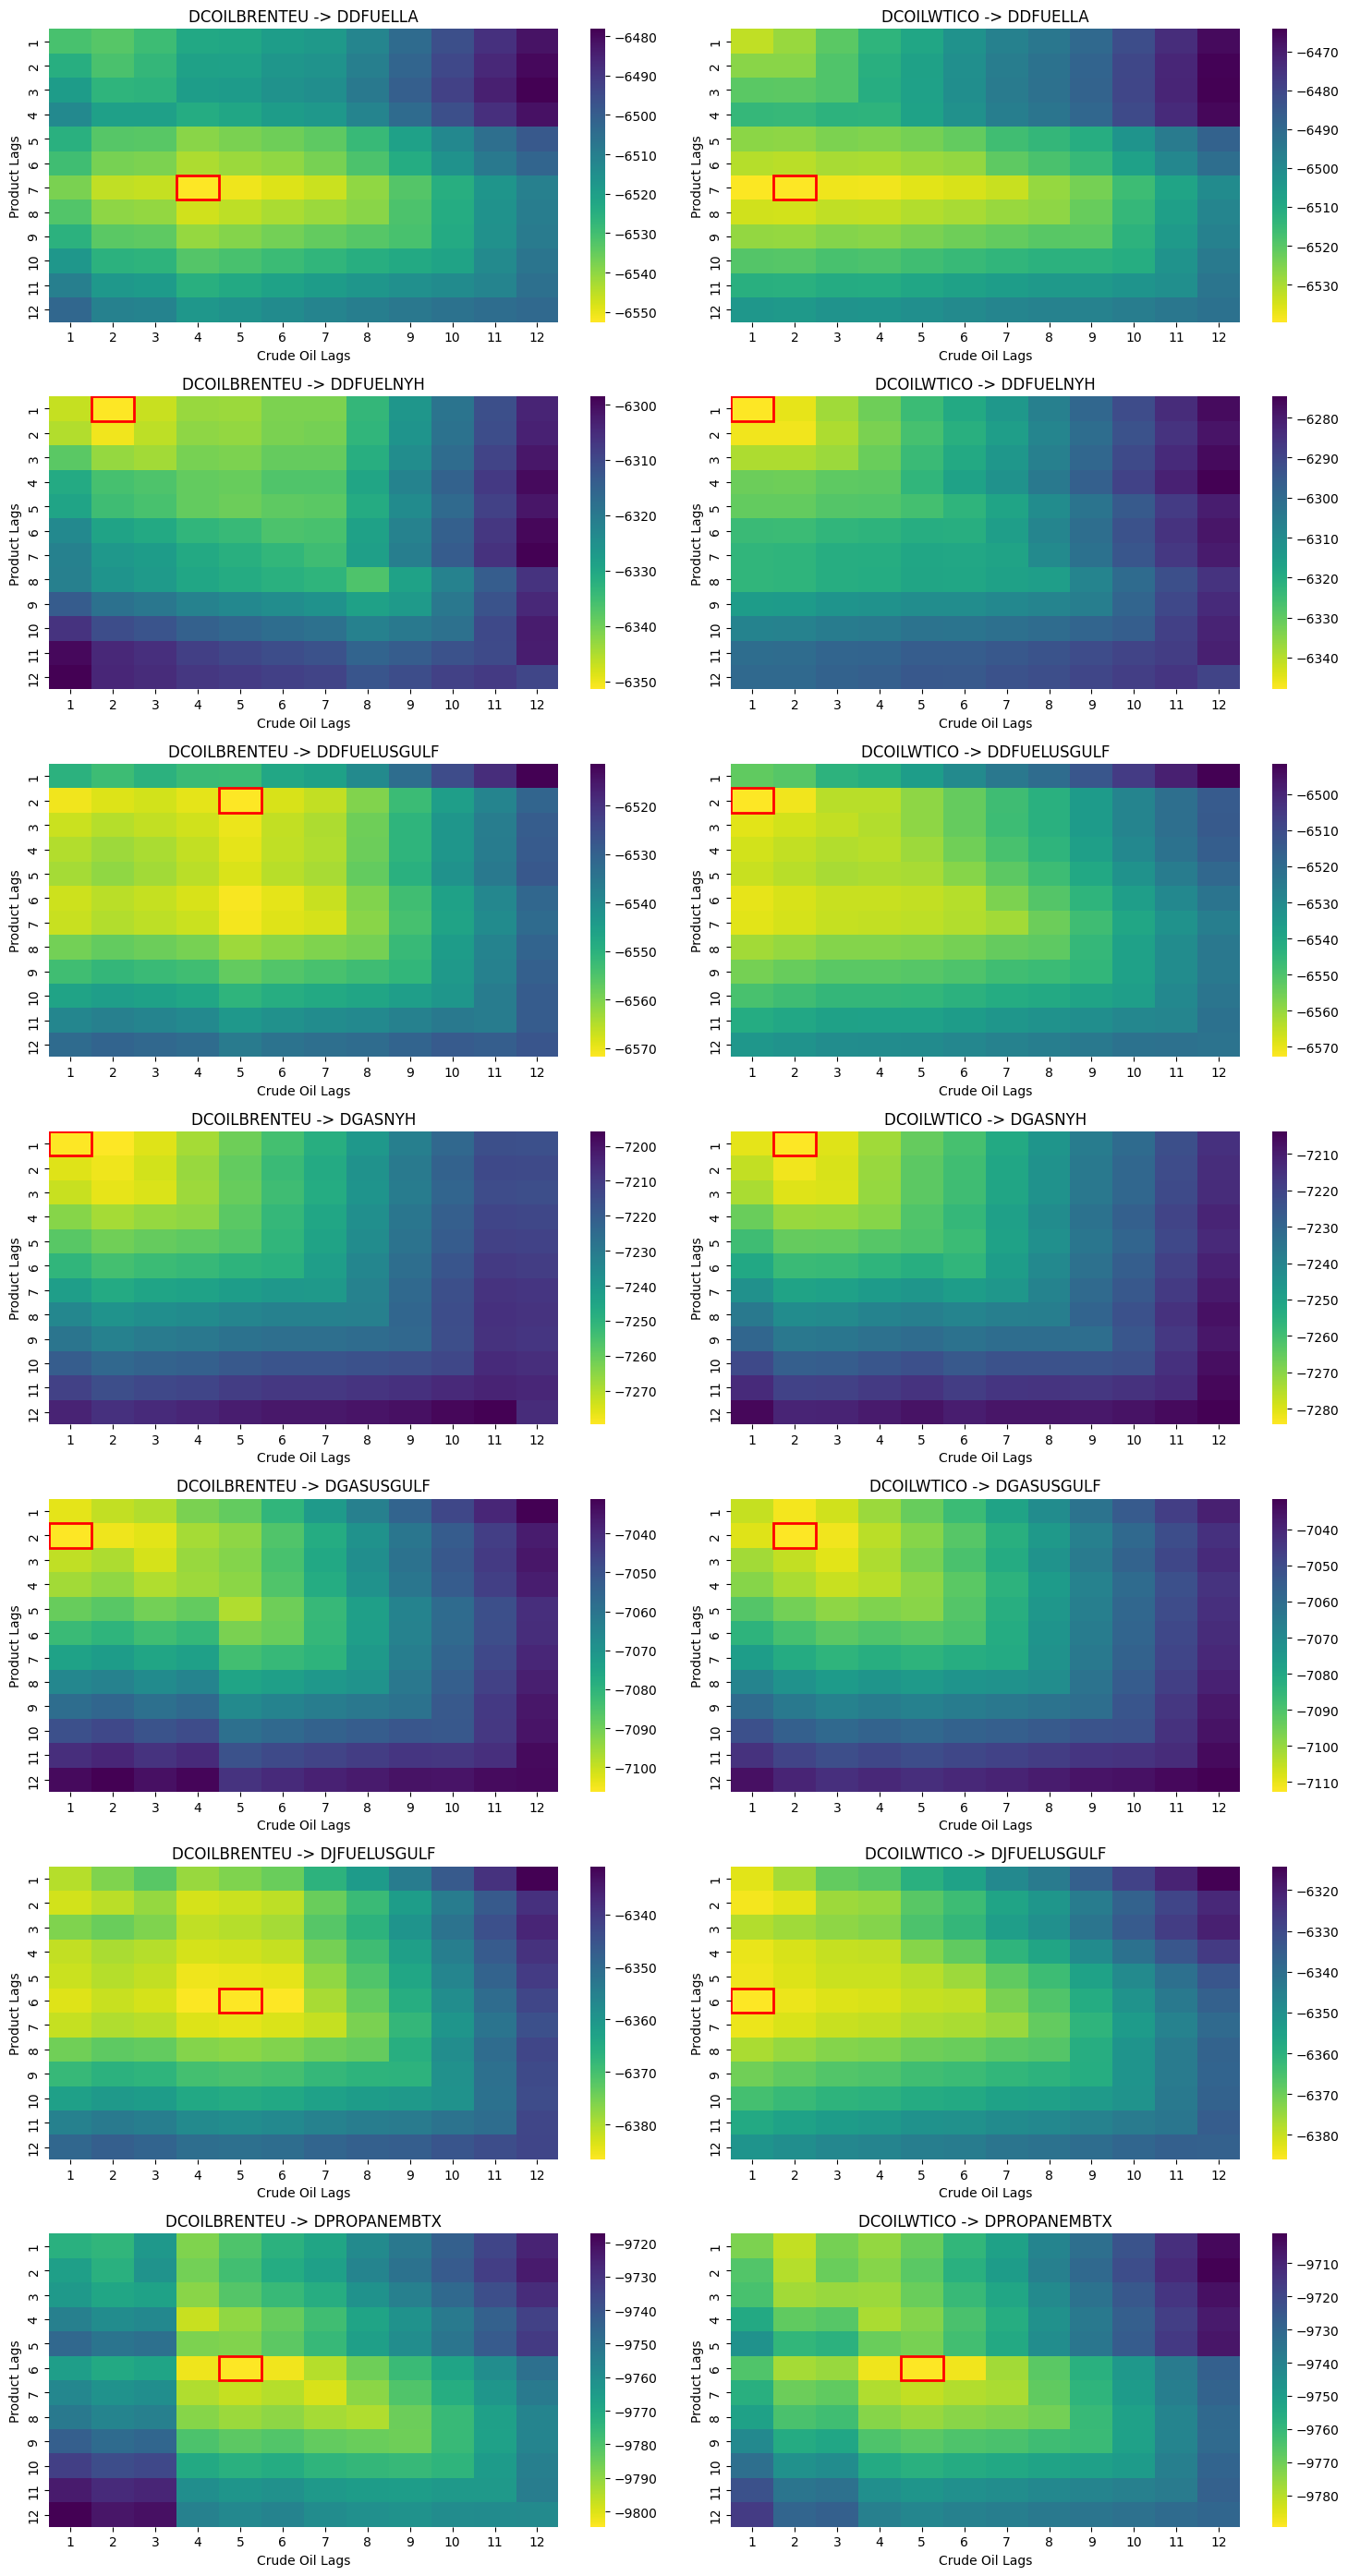


DCOILBRENTEU -> DDFUELLA
Optimal lags: Y=7, X=4
Minimum AIC: -6552.55

DCOILWTICO -> DDFUELLA
Optimal lags: Y=7, X=2
Minimum AIC: -6539.60

DCOILBRENTEU -> DDFUELNYH
Optimal lags: Y=1, X=2
Minimum AIC: -6351.49

DCOILWTICO -> DDFUELNYH
Optimal lags: Y=1, X=1
Minimum AIC: -6347.98

DCOILBRENTEU -> DDFUELUSGULF
Optimal lags: Y=2, X=5
Minimum AIC: -6571.84

DCOILWTICO -> DDFUELUSGULF
Optimal lags: Y=2, X=1
Minimum AIC: -6572.78

DCOILBRENTEU -> DGASNYH
Optimal lags: Y=1, X=1
Minimum AIC: -7279.61

DCOILWTICO -> DGASNYH
Optimal lags: Y=1, X=2
Minimum AIC: -7284.24

DCOILBRENTEU -> DGASUSGULF
Optimal lags: Y=2, X=1
Minimum AIC: -7106.35

DCOILWTICO -> DGASUSGULF
Optimal lags: Y=2, X=2
Minimum AIC: -7112.75

DCOILBRENTEU -> DJFUELUSGULF
Optimal lags: Y=6, X=5
Minimum AIC: -6386.64

DCOILWTICO -> DJFUELUSGULF
Optimal lags: Y=6, X=1
Minimum AIC: -6385.99

DCOILBRENTEU -> DPROPANEMBTX
Optimal lags: Y=6, X=5
Minimum AIC: -9804.54

DCOILWTICO -> DPROPANEMBTX
Optimal lags: Y=6, X=5
Minimum AIC: -

In [187]:
def calculate_aic_grid(y, x, max_lags=12):
    """Calculate AIC for all lag combinations"""
    aic_grid = np.zeros((max_lags, max_lags))
    
    for y_lags, x_lags in iterproduct(range(1, max_lags+1), range(1, max_lags+1)):
        # Create DataFrames for each iteration
        X = pd.DataFrame()
        for i in range(y_lags):
            X[f'y_lag_{i+1}'] = y.shift(i+1)
        for i in range(x_lags):
            X[f'x_lag_{i+1}'] = x.shift(i+1)
            
        # Drop NaN rows
        X = X.dropna()
        y_trim = y[X.index[0]:]
        
        if len(y_trim) < 30:  # Skip if not enough data
            aic_grid[y_lags-1, x_lags-1] = np.nan
            continue
            
        try:
            model = OLS(y_trim, sm.add_constant(X))
            results = model.fit()
            
            # Calculate AIC
            aic = len(y_trim) * np.log(np.var(results.resid)) + 2 * (y_lags + x_lags)
            aic_grid[y_lags-1, x_lags-1] = aic
        except:
            aic_grid[y_lags-1, x_lags-1] = np.nan
            
    return aic_grid

# Create subplots for each combination
n_dists = len(dists.columns)
n_crudes = len(crudes.columns)
fig, axes = plt.subplots(n_dists, n_crudes, figsize=(15, 4*n_dists))

for i, dist in enumerate(dists.columns):
    for j, crude in enumerate(crudes.columns):
        # Calculate AIC grid
        aic_grid = calculate_aic_grid(dists[dist], crudes[crude])
        
        # Find the optimal (minimum) AIC position
        optimal_y, optimal_x = np.unravel_index(np.nanargmin(aic_grid), aic_grid.shape)
        
        # Create heatmap
        if n_dists == 1:
            ax = axes[j]
        else:
            ax = axes[i,j]
            
        sns.heatmap(aic_grid, 
                   ax=ax,
                   cmap='viridis_r',
                   xticklabels=range(1,13),
                   yticklabels=range(1,13))
        
        # Add red rectangle around optimal point
        ax.add_patch(plt.Rectangle((optimal_x, optimal_y), 1, 1, 
                                 fill=False, edgecolor='red', 
                                 linewidth=2))
        
        ax.set_xlabel('Crude Oil Lags')
        ax.set_ylabel('Product Lags')
        ax.set_title(f'{crude} -> {dist}')

plt.tight_layout()
plt.show()

# Optional: Print the optimal lags for each combination
for dist in dists.columns:
    for crude in crudes.columns:
        aic_grid = calculate_aic_grid(dists[dist], crudes[crude])
        optimal_y, optimal_x = np.unravel_index(np.nanargmin(aic_grid), aic_grid.shape)
        print(f"\n{crude} -> {dist}")
        print(f"Optimal lags: Y={optimal_y+1}, X={optimal_x+1}")
        print(f"Minimum AIC: {np.nanmin(aic_grid):.2f}")

In [188]:
results_dict = {}
for crude in crudes.columns:
    for dist in dists.columns:
        print(f"\nAnalyzing {crude} -> {dist}")
        
        try:
            # Create fresh copies of the series
            crude_series = crudes[crude].copy()
            dist_series = dists[dist].copy()
            
            # Get common date range
            common_idx = crude_series.index.intersection(dist_series.index)
            crude_series = crude_series[common_idx]
            dist_series = dist_series[common_idx]
            
            # Remove any remaining NaN values
            valid_idx = ~(crude_series.isna() | dist_series.isna())
            crude_series = crude_series[valid_idx]
            dist_series = dist_series[valid_idx]
            
            if len(crude_series) < 30:
                print(f"Not enough data for {crude} -> {dist} analysis")
                continue
                
            # Find optimal lags
            optimal_lags = find_optimal_lags(dist_series, crude_series)
            print(f"Optimal lags: Y={optimal_lags[0]}, X={optimal_lags[1]}")
            
            # Calculate metrics
            metrics = calculate_f_statistic(dist_series, crude_series, 
                                         optimal_lags[0], optimal_lags[1])
            
            print(f"Variance Reduction: {metrics['var_improvement']:.2f}%")
            print(f"R-squared: {metrics['r2_unrestricted']:.4f} (with crude) vs {metrics['r2_restricted']:.4f} (without crude)")
            print(f"R-squared Improvement: {metrics['r2_improvement']:.2f} percentage points")
            print(f"F-stat: {metrics["f_stat"]:.2f}")
            # Store results
            results_dict[(crude, dist)] = metrics
            
        except Exception as e:
            print(f"Error analyzing {crude} -> {dist}: {str(e)}")



Analyzing DCOILBRENTEU -> DDFUELLA
Optimal lags: Y=7, X=4
Variance Reduction: 2.02%
R-squared: 0.9911 (with crude) vs 0.9909 (without crude)
R-squared Improvement: 0.02 percentage points
F-stat: 0.02

Analyzing DCOILBRENTEU -> DDFUELNYH
Optimal lags: Y=1, X=2
Variance Reduction: 1.39%
R-squared: 0.9907 (with crude) vs 0.9906 (without crude)
R-squared Improvement: 0.01 percentage points
F-stat: 0.01

Analyzing DCOILBRENTEU -> DDFUELUSGULF
Optimal lags: Y=2, X=5
Variance Reduction: 2.56%
R-squared: 0.9911 (with crude) vs 0.9909 (without crude)
R-squared Improvement: 0.02 percentage points
F-stat: 0.03

Analyzing DCOILBRENTEU -> DGASNYH
Optimal lags: Y=1, X=1
Variance Reduction: 0.02%
R-squared: 0.9925 (with crude) vs 0.9925 (without crude)
R-squared Improvement: 0.00 percentage points
F-stat: 0.00

Analyzing DCOILBRENTEU -> DGASUSGULF
Optimal lags: Y=2, X=1
Variance Reduction: 0.05%
R-squared: 0.9912 (with crude) vs 0.9912 (without crude)
R-squared Improvement: 0.00 percentage points
F-

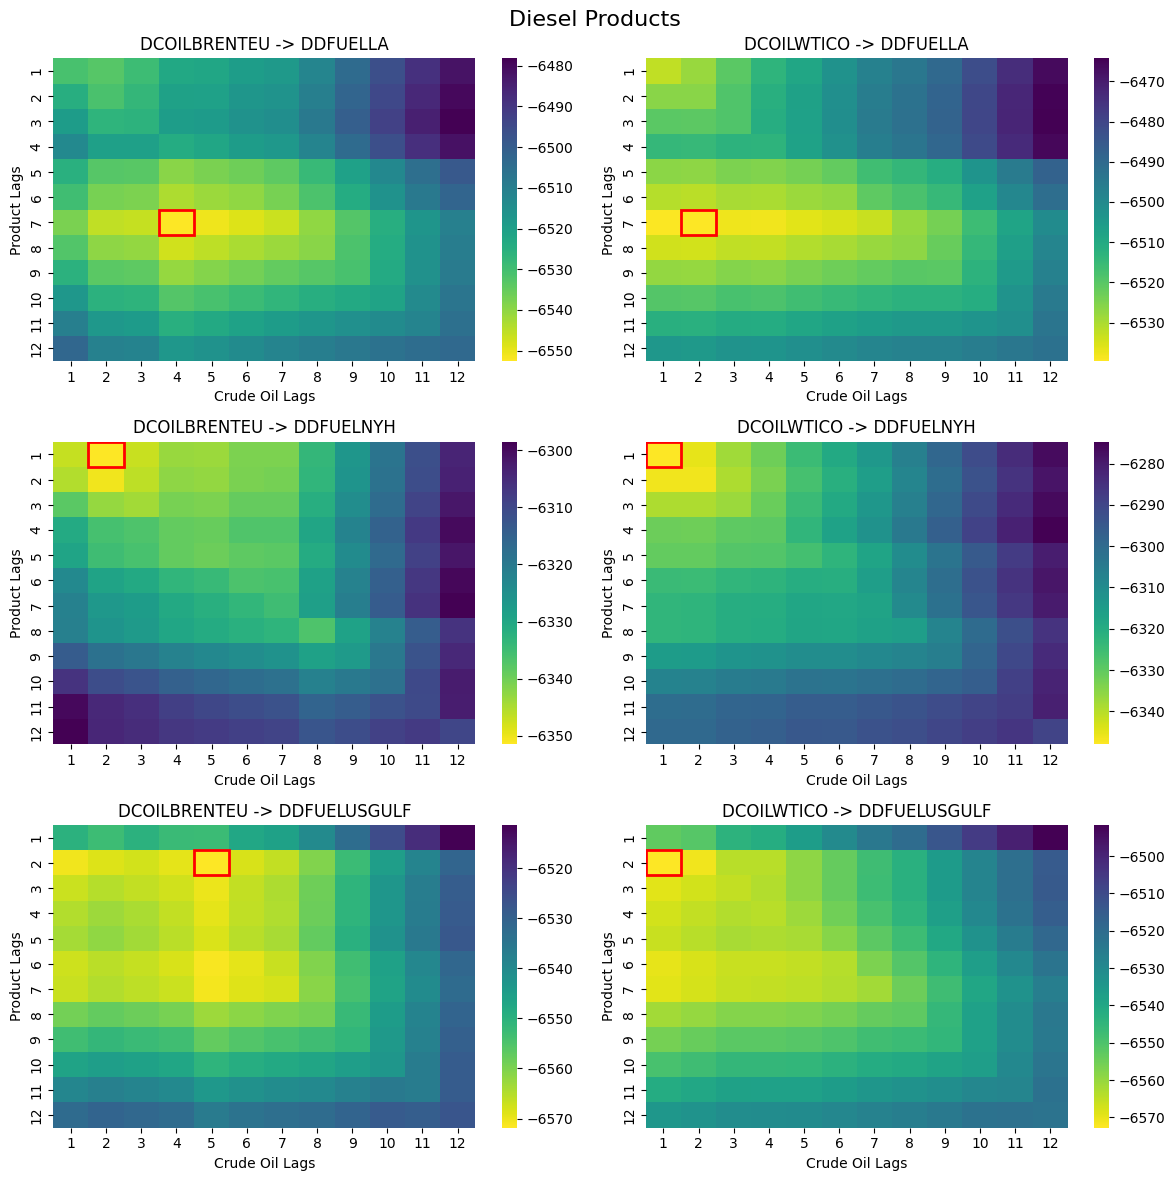

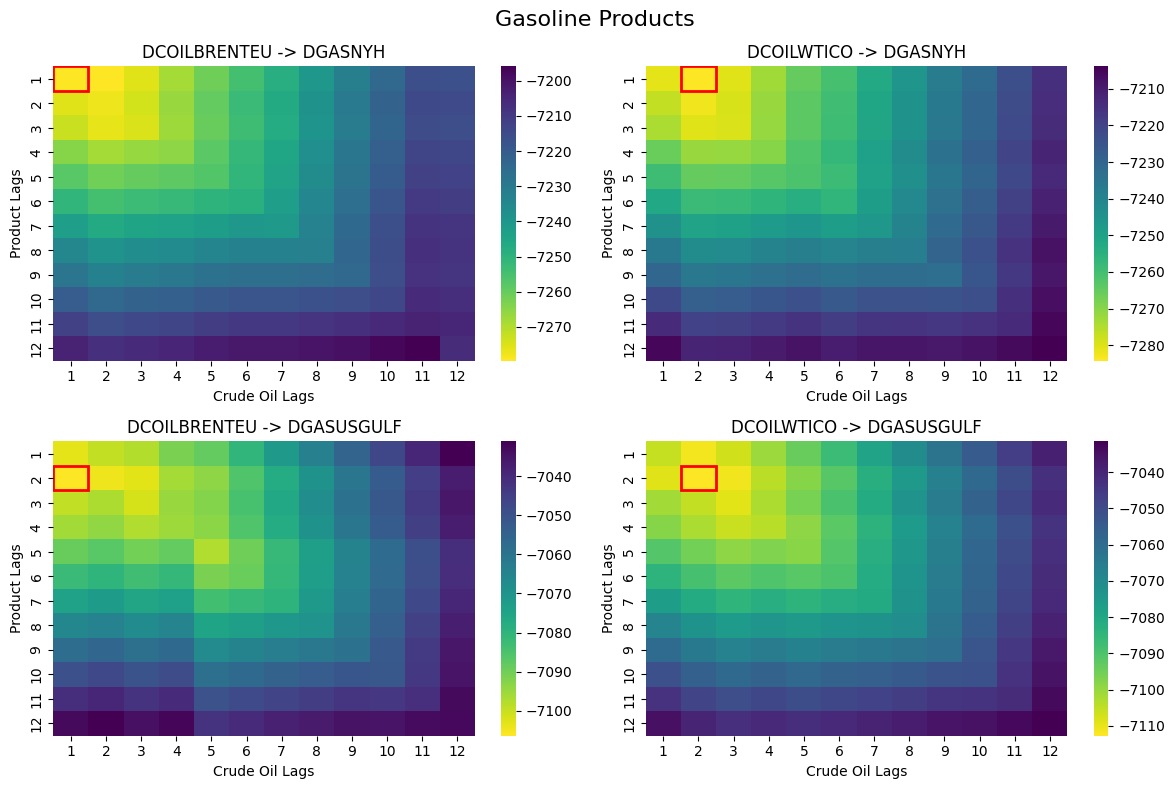

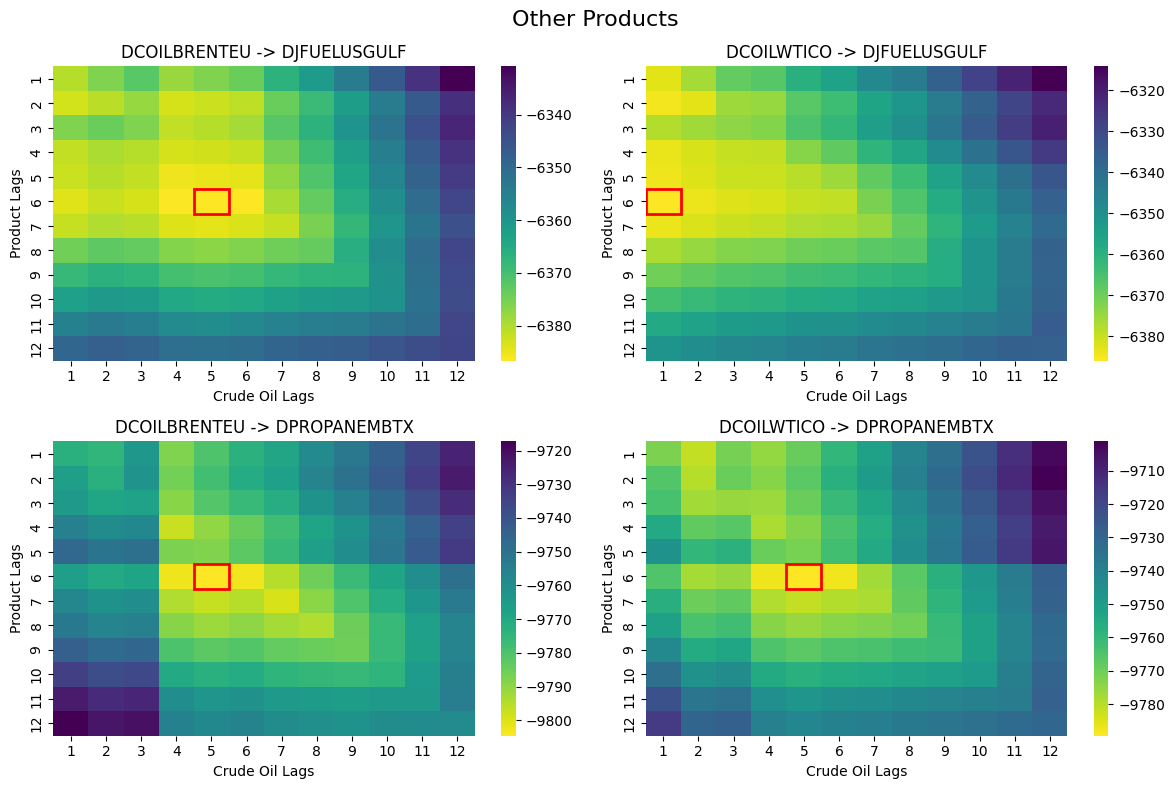

In [189]:
def plot_product_class(product_list, crudes, dists, title):
    n_products = len(product_list)
    fig, axes = plt.subplots(n_products, 2, figsize=(12, 4*n_products))
    fig.suptitle(title, fontsize=16)
    
    for i, dist in enumerate(product_list):
        for j, crude in enumerate(crudes.columns):
            aic_grid = calculate_aic_grid(dists[dist], crudes[crude])
            optimal_y, optimal_x = np.unravel_index(np.nanargmin(aic_grid), aic_grid.shape)
            
            sns.heatmap(aic_grid, 
                       ax=axes[i,j],
                       cmap='viridis_r',
                       xticklabels=range(1,13),
                       yticklabels=range(1,13))
            
            axes[i,j].add_patch(plt.Rectangle((optimal_x, optimal_y), 1, 1, 
                                            fill=False, edgecolor='red', 
                                            linewidth=2))
            
            axes[i,j].set_xlabel('Crude Oil Lags')
            axes[i,j].set_ylabel('Product Lags')
            axes[i,j].set_title(f'{crude} -> {dist}')
    
    plt.tight_layout()
    plt.show()

# Plot each product class
plot_product_class(diesel_products, crudes, dists, "Diesel Products")
plot_product_class(gasoline_products, crudes, dists, "Gasoline Products")
plot_product_class(other_products, crudes, dists, "Other Products")

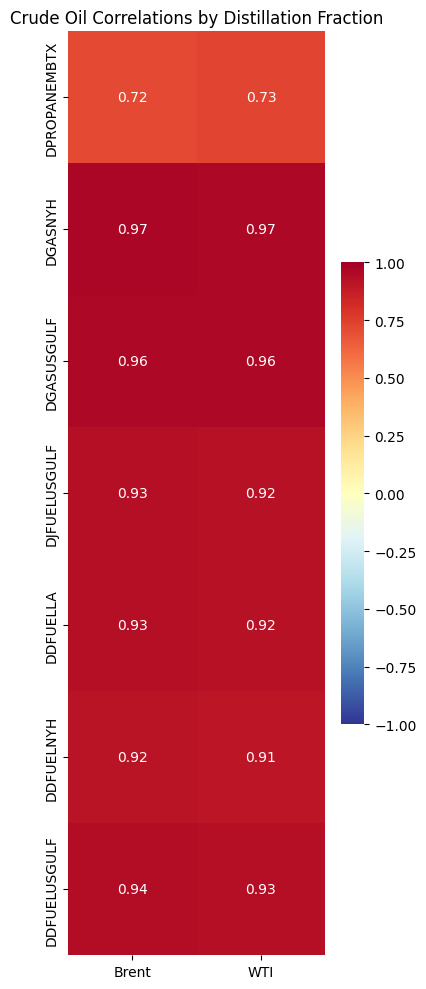

In [190]:
# Order products by distillation process
distillation_order = [
    'DPROPANEMBTX',  # Propane (lightest, -42°C boiling point)
    'DGASNYH',       # Gasoline (40-200°C)
    'DGASUSGULF',    # Gasoline
    'DJFUELUSGULF',  # Jet Fuel (150-300°C)
    'DDFUELLA',      # Diesel (200-350°C)
    'DDFUELNYH',     # Diesel
    'DDFUELUSGULF'   # Diesel
]

# Create figure
fig, ax = plt.subplots(figsize=(4, 10))

# Get and organize correlations
brent_corr = pd.concat([crudes['DCOILBRENTEU'], dists], axis=1).corr().iloc[0:1, 1:]
wti_corr = pd.concat([crudes['DCOILWTICO'], dists], axis=1).corr().iloc[0:1, 1:]

# Combine and transpose
combined_corr = pd.concat([brent_corr, wti_corr])
combined_corr.index = ['Brent', 'WTI']
combined_corr = combined_corr.T

# Reorder by distillation process
combined_corr = combined_corr.reindex(distillation_order)

# Create heatmap
sns.heatmap(combined_corr, 
            annot=True,  
            fmt='.2f',   
            cmap='RdYlBu_r',  
            vmin=-1, vmax=1,  
            center=0,    
            cbar_kws={"shrink": .5})

plt.title('Crude Oil Correlations by Distillation Fraction')
plt.tight_layout()
plt.show()

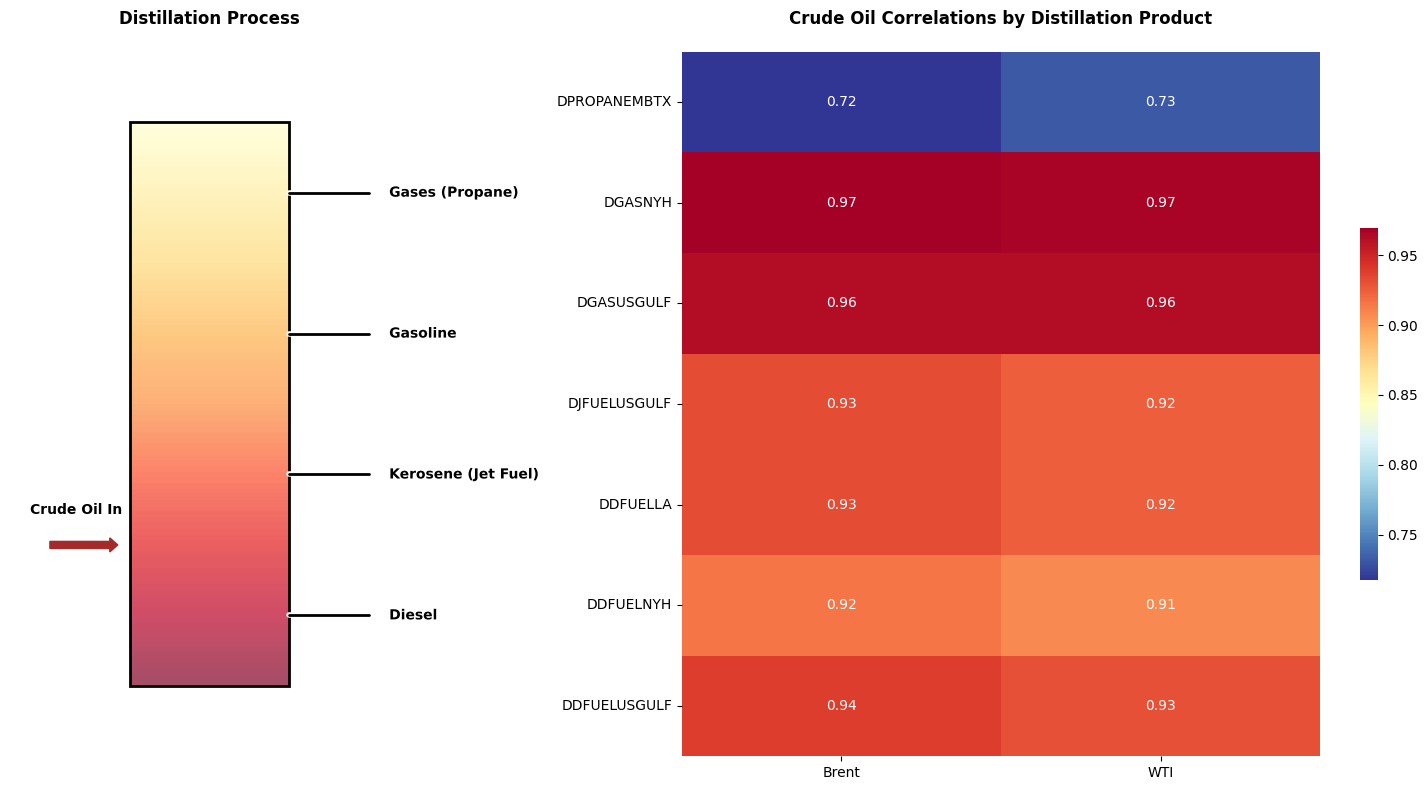

In [191]:

from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 2]})

# Left subplot: Enhanced distillation tower
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Create gradient colors for tower - flipped direction
gradient = np.linspace(0, 1, 100)
gradient = np.vstack((gradient, gradient))

# Draw tower with gradient and better styling
tower = Rectangle((0.3, 0.1), 0.4, 0.8, 
                 facecolor='none',  
                 edgecolor='black',
                 linewidth=2)
ax1.add_patch(tower)

# Add gradient background to tower - using YlOrRd instead of YlOrRd_r
ax1.imshow(gradient.T, 
           extent=[0.3, 0.7, 0.1, 0.9], 
           aspect='auto', 
           cmap='YlOrRd',  # Removed the '_r' to flip the gradient
           alpha=0.7)

# Add product labels and lines with better styling
products = ['Gases (Propane)', 'Gasoline', 'Kerosene (Jet Fuel)', 'Diesel']
heights = [0.8, 0.6, 0.4, 0.2]
colors = ['#FFE5B4', '#FFB6C1', '#ADD8E6', '#90EE90']  # pastel colors for each product

for product, height, color in zip(products, heights, colors):
    # Draw horizontal line from tower
    line = ax1.plot([0.7, 0.9], [height, height], '-', 
                    color='black', 
                    lw=2,
                    solid_capstyle='round')[0]
    line.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])
    
    # Add product label with better styling
    text = ax1.text(0.95, height, product, 
                    va='center',
                    ha='left',
                    fontweight='bold',
                    fontsize=10)
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add crude oil input arrow
ax1.arrow(0.1, 0.3, 0.15, 0, 
          head_width=0.02, 
          head_length=0.02, 
          fc='brown', 
          ec='brown',
          width=0.01)
ax1.text(0.05, 0.35, 'Crude Oil In', va='center', fontweight='bold')


ax1.axis('off')
ax1.set_title('Distillation Process', pad=20, fontsize=12, fontweight='bold')

# Right subplot: Correlation heatmap
distillation_order = [
    'DPROPANEMBTX',  
    'DGASNYH',      
    'DGASUSGULF',    
    'DJFUELUSGULF',  
    'DDFUELLA',     
    'DDFUELNYH',     
    'DDFUELUSGULF'
]

brent_corr = pd.concat([crudes['DCOILBRENTEU'], dists], axis=1).corr().iloc[0:1, 1:]
wti_corr = pd.concat([crudes['DCOILWTICO'], dists], axis=1).corr().iloc[0:1, 1:]

combined_corr = pd.concat([brent_corr, wti_corr])
combined_corr.index = ['Brent', 'WTI']
combined_corr = combined_corr.T
combined_corr = combined_corr.reindex(distillation_order)

# Find the range of actual correlations
vmin = combined_corr.min().min()
vmax = combined_corr.max().max()

# Create heatmap with adjusted scale
sns.heatmap(combined_corr, 
            annot=True,  
            fmt='.2f',   
            cmap='RdYlBu_r',  
            vmin=vmin,    # Use actual minimum
            vmax=vmax,    # Use actual maximum
            center=np.mean([vmin, vmax]),  # Center at the midpoint
            cbar_kws={"shrink": .5},
            ax=ax2)

ax2.set_title('Crude Oil Correlations by Distillation Product', pad=20, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [192]:
def get_energy_season(date):
    # Based on typical energy demand patterns
    month = date.month
    if month in [12, 1, 2]:
        return 'Peak_Winter'  # Heating demand
    elif month in [6, 7, 8]:
        return 'Peak_Summer'  # Cooling demand
    else:
        return 'Shoulder'     # Transition periods
    
# Add season column to your dataframe
returns_df['season'] = returns_df.index.map(get_energy_season)  # or get_energy_season or get_quarter


C:\Users\dbjac\AppData\Local\Temp\ipykernel_25084\79245811.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df['season'] = returns_df.index.map(get_energy_season)  # or get_energy_season or get_quarter


In [193]:
seasons = returns_df['season'].unique()
seasonal_results = {}

for season in seasons:
    print(f"\nAnalyzing {season}")
    season_data = returns_df[returns_df['season'] == season]
    
    # Get seasonal price data
    season_crudes = crudes.loc[season_data.index]
    season_dists = dists.loc[season_data.index]
    
    # Dictionary to store results for this season
    season_results = {}
    
    for crude in season_crudes.columns:
        for dist in season_dists.columns:
            try:
                # Create fresh copies of the series
                crude_series = season_crudes[crude].copy()
                dist_series = season_dists[dist].copy()
                
                # Get common date range
                common_idx = crude_series.index.intersection(dist_series.index)
                crude_series = crude_series[common_idx]
                dist_series = dist_series[common_idx]
                
                # Remove any remaining NaN values
                valid_idx = ~(crude_series.isna() | dist_series.isna())
                crude_series = crude_series[valid_idx]
                dist_series = dist_series[valid_idx]
                
                if len(crude_series) < 30:  # minimum required observations
                    print(f"Not enough data for {crude} -> {dist} in {season}")
                    continue
                    
                # Find optimal lags
                optimal_lags = find_optimal_lags(dist_series, crude_series)
                
                # Calculate metrics
                metrics = calculate_f_statistic(dist_series, crude_series, 
                                             optimal_lags[0], optimal_lags[1])
                
                # Store results
                season_results[(crude, dist)] = {
                    'optimal_lags': optimal_lags,
                    'variance_reduction': metrics['var_improvement'],
                    'r2_restricted': metrics['r2_restricted'],
                    'r2_unrestricted': metrics['r2_unrestricted'],
                    'f_stat': metrics['f_stat']
                }
                
                print(f"\n{crude} -> {dist}")
                print(f"Optimal lags: Y={optimal_lags[0]}, X={optimal_lags[1]}")
                print(f"Variance Reduction: {metrics['var_improvement']:.2f}%")
                print(f"R-squared: {metrics['r2_unrestricted']:.4f} (with crude) vs {metrics['r2_restricted']:.4f} (without crude)")
                print(f"F-stat: {metrics['f_stat']:.2f}")
                
            except Exception as e:
                print(f"Error analyzing {crude} -> {dist} in {season}: {str(e)}")
    
    seasonal_results[season] = season_results

# Create summary tables for each product type
def create_seasonal_summary(product_list, seasonal_results):
    summary_data = []
    for season in seasonal_results:
        for crude in ['DCOILBRENTEU', 'DCOILWTICO']:
            for dist in product_list:
                if (crude, dist) in seasonal_results[season]:
                    result = seasonal_results[season][(crude, dist)]
                    summary_data.append({
                        'Season': season,
                        'Region': dist,
                        'Crude': crude,
                        'Optimal_Lags': f"({result['optimal_lags'][0]},{result['optimal_lags'][1]})",
                        'Variance_Reduction': f"{result['variance_reduction']:.2f}%",
                        'F_stat': f"{result['f_stat']:.2f}"
                    })
    
    return pd.DataFrame(summary_data)

# Create summaries for each product type
diesel_products = ['DDFUELLA', 'DDFUELNYH', 'DDFUELUSGULF']
gasoline_products = ['DGASNYH', 'DGASUSGULF']
other_products = ['DJFUELUSGULF', 'DPROPANEMBTX']

diesel_summary = create_seasonal_summary(diesel_products, seasonal_results)
gasoline_summary = create_seasonal_summary(gasoline_products, seasonal_results)
other_summary = create_seasonal_summary(other_products, seasonal_results)


Analyzing Peak_Summer

DCOILBRENTEU -> DDFUELLA
Optimal lags: Y=1, X=1
Variance Reduction: 0.21%
R-squared: 0.9544 (with crude) vs 0.9544 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DDFUELNYH
Optimal lags: Y=1, X=1
Variance Reduction: 0.45%
R-squared: 0.9616 (with crude) vs 0.9614 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DDFUELUSGULF
Optimal lags: Y=1, X=1
Variance Reduction: 0.50%
R-squared: 0.9623 (with crude) vs 0.9621 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DGASNYH
Optimal lags: Y=1, X=1
Variance Reduction: 0.09%
R-squared: 0.9637 (with crude) vs 0.9636 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DGASUSGULF
Optimal lags: Y=1, X=1
Variance Reduction: 0.37%
R-squared: 0.9653 (with crude) vs 0.9652 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DJFUELUSGULF
Optimal lags: Y=1, X=1
Variance Reduction: 0.49%
R-squared: 0.9641 (with crude) vs 0.9640 (without crude)
F-stat: 0.00

DCOILBRENTEU -> DPROPANEMBTX
Optimal lags: Y=1, X=1
Variance Reduction: 0.61%
R-squared: 0.9757 

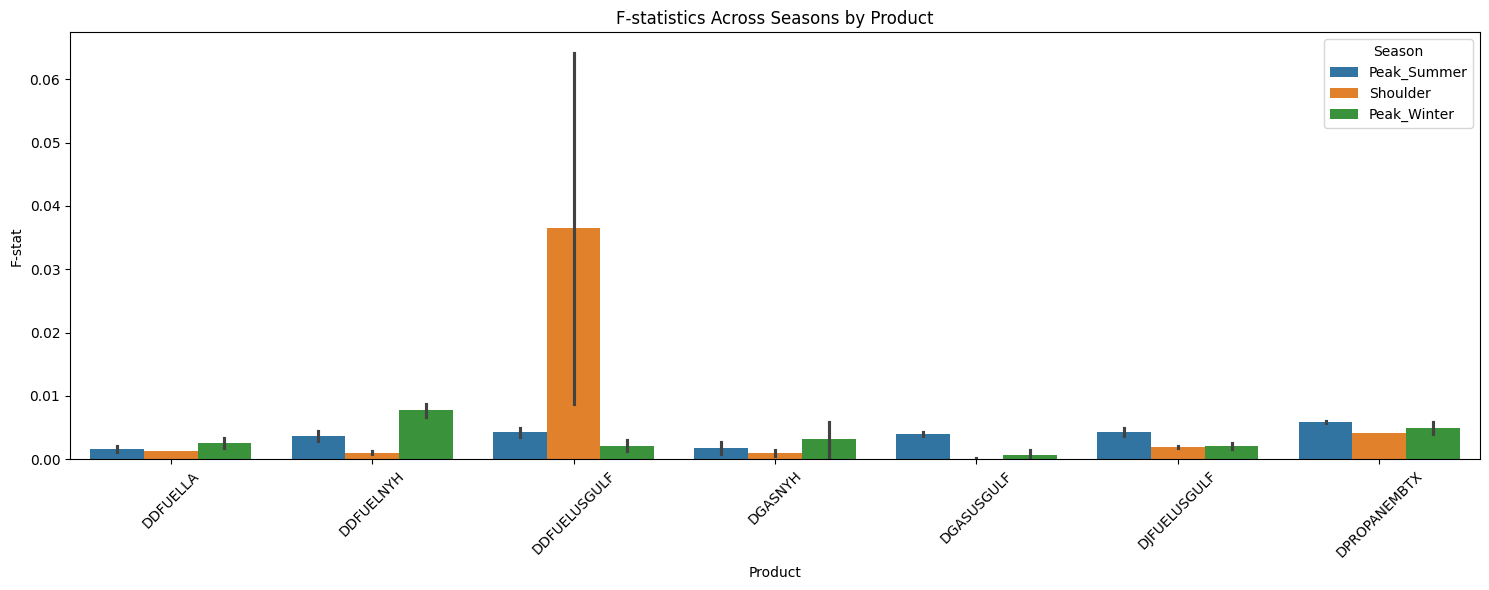

In [194]:

# Create DataFrame for plotting
plot_data = []
for season in seasonal_results:
    for (crude, dist), results in seasonal_results[season].items():
        plot_data.append({
            'Season': season,
            'Crude': crude,
            'Product': dist,
            'F-stat': results['f_stat'],
            'Variance_Reduction': results['variance_reduction']
        })
plot_df = pd.DataFrame(plot_data)

# Bar plot of F-stats by season
plt.figure(figsize=(15, 6))
sns.barplot(data=plot_df, x='Product', y='F-stat', hue='Season')
plt.xticks(rotation=45)
plt.title('F-statistics Across Seasons by Product')
plt.tight_layout()
plt.show()

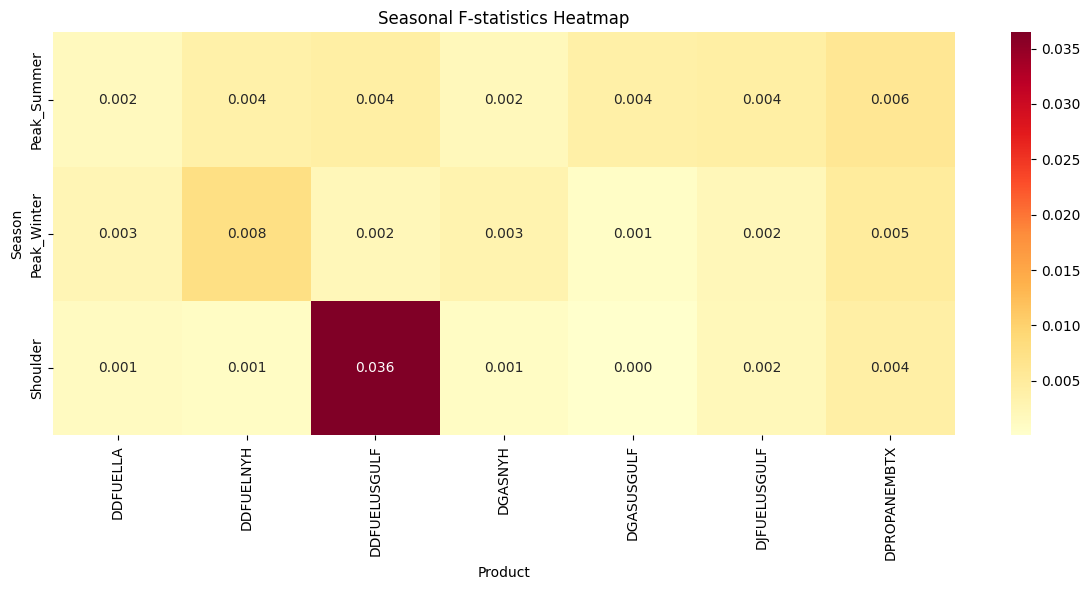

In [195]:
# Pivot table for heatmap
heatmap_data = plot_df.pivot_table(
    values='F-stat',
    index='Season',
    columns='Product'
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Seasonal F-statistics Heatmap')
plt.tight_layout()
plt.show()